In [1]:
%run supervised_functions.ipynb

# Generate data

In [2]:
start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

In [3]:
np.random.seed(42)

N = 100000
steps = 5

df_list = []
final_shape = 0
smiles_per_random_sample = 1000
pool_chunk_size = 10

# Create dataset for multi-step pred
with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
    while final_shape < N:
        smiles = np.random.choice(start_mols, size=(smiles_per_random_sample,))

        for new_df in p.imap_unordered(functools.partial(generate_train_data, steps=steps), smiles, chunksize=10):
            df_list.append(new_df)
            final_shape += new_df.shape[0]
            
        pbar.update(final_shape - pbar.n)

main_df = pd.concat(df_list)
del df_list
print(main_df.shape)

# randomize
main_df = pd.concat([main_df[:int(main_df.shape[0]*0.8)].sample(frac=1), main_df[int(main_df.shape[0]*0.8):].sample(frac=1)])
print(main_df.shape)

107702it [01:59, 902.27it/s]                                                                         


(107702, 10)
(107702, 10)


# Networks

In [4]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Helper stuff

In [5]:
%%time
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

(89384, 8)


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ge`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ti`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_

CPU times: user 3min 31s, sys: 5.35 s, total: 3min 36s
Wall time: 3min 21s


In [6]:
# I'm storing as lists, so doing numpy operations for the elements
correct_applicable_indices = []
correct_action_dataset_indices = []
action_embedding_indices = []

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df.iterrows()), total=main_df.shape[0]):
with Pool(20) as p:
    for indices_used_for_data, correct_app_idx, correct_act_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df.iterrows(), chunksize=50), total=main_df.shape[0]):
        action_embedding_indices.append(indices_used_for_data)
        correct_applicable_indices.append(correct_app_idx)
        correct_action_dataset_indices.append(correct_act_idx)

100%|███████████████████████████████████████████████████████| 107702/107702 [04:22<00:00, 409.66it/s]


# Training

In [40]:
train_idx = np.arange(0, int(main_df.shape[0]*0.8))
test_idx = np.arange(int(main_df.shape[0]*0.8), main_df.shape[0])

train_idx = torch.arange(0, int(main_df.shape[0]*0.8))[:500]
test_idx = torch.arange(int(main_df.shape[0]*0.8), main_df.shape[0])[-200:]

In [41]:
%%time
%matplotlib inline
train_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["reactant"]))).to(device)
train_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["product"]))).to(device)
train_rsigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["rsig"]))).to(device)
train_psigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["psig"]))).to(device)

test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["reactant"]))).to(device)
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["product"]))).to(device)
test_rsigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["rsig"]))).to(device)
test_psigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["psig"]))).to(device)

print(train_reactants.batch_size, train_products.batch_size, train_rsigs.batch_size, train_psigs.batch_size)
print(test_reactants.batch_size, test_products.batch_size, test_rsigs.batch_size, test_psigs.batch_size)

/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Pb`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `As`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)


86161 86161 86161 86161
21541 21541 21541 21541
CPU times: user 11min 20s, sys: 26.5 s, total: 11min 47s
Wall time: 11min 4s


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.14it/s]


Epoch 1/50. Batch 86016/86033. Train loss = 0.082570



100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.82it/s]


╒════╤══════════╤══════════╤═══════════╤═══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │     GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪═══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│  1 │ 0.023856 │ 0.023856 │         1 │ 0.0466004 │     0.992188 │     0.992188 │             1 │    0.996078 │   0.508022 │   0.023856 │    0.753304 │ 0.0462475 │ 8.72 min                │
╘════╧══════════╧══════════╧═══════════╧═══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

BEST MODEL UPDATED! BEST GT_f1 = 0.046600354

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.92it/s]


╒════╤═══════════╤═══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │    GT_acc │    GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪═══════════╪═══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│  2 │ 0.0560826 │ 0.0560826 │         1 │ 0.106209 │      0.99149 │      0.99149 │             1 │    0.995727 │   0.523786 │  0.0560826 │    0.868251 │   0.10536 │ 8.33 min                │
╘════╧═══════════╧═══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

BEST MODEL UPDATED! BEST GT_f1 = 0.1062

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.28it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│  3 │ 0.120536 │ 0.120536 │         1 │ 0.215139 │     0.985166 │     0.985166 │             1 │    0.992527 │   0.552851 │   0.120536 │    0.890416 │  0.212328 │ 7.78 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

BEST MODEL UPDATED! BEST GT_f1 = 0.21513944223107

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.01it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│  4 │  0.18936 │  0.18936 │         1 │ 0.318424 │     0.972563 │     0.972563 │             1 │    0.986091 │   0.580962 │    0.18936 │    0.873445 │  0.311244 │ 7.96 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

BEST MODEL UPDATED! BEST GT_f1 = 0.31842352205192

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.16it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│  5 │ 0.222145 │ 0.222145 │         1 │ 0.363533 │     0.966471 │     0.966471 │             1 │     0.98295 │   0.594308 │   0.222145 │    0.868861 │  0.353826 │ 8.51 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

BEST MODEL UPDATED! BEST GT_f1 = 0.36353259008409

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.63it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│  6 │ 0.238281 │ 0.238281 │         1 │ 0.384858 │     0.970285 │     0.970285 │             1 │    0.984918 │   0.604283 │   0.238281 │     0.88912 │  0.375839 │ 8.57 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

BEST MODEL UPDATED! BEST GT_f1 = 0.38485804416403

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.67it/s]


╒════╤══════════╤══════════╤═══════════╤═════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │   GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪═════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│  7 │ 0.349609 │ 0.349609 │         1 │ 0.51809 │     0.935593 │     0.935593 │             1 │    0.966725 │   0.642601 │   0.349609 │    0.844434 │  0.494491 │ 8.48 min                │
╘════╧══════════╧══════════╧═══════════╧═════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

BEST MODEL UPDATED! BEST GT_f1 = 0.5180897250361794
Ep

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.53it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│  8 │ 0.333287 │ 0.333287 │         1 │ 0.499948 │     0.946847 │     0.946847 │             1 │    0.972698 │   0.640067 │   0.333287 │    0.862455 │  0.480781 │ 8.53 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 9/50. Batch 86016/86033. Train loss = 0.043

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.41it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│  9 │ 0.341843 │ 0.341843 │         1 │ 0.509513 │     0.948289 │     0.948289 │             1 │    0.973458 │   0.645066 │   0.341843 │    0.868605 │  0.490606 │ 8.57 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 10/50. Batch 86016/86033. Train loss = 0.03

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.78it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 10 │ 0.426618 │ 0.426618 │         1 │ 0.598083 │     0.923038 │     0.923038 │             1 │    0.959979 │   0.674828 │   0.426618 │     0.84717 │   0.56747 │ 8.35 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

BEST MODEL UPDATED! BEST GT_f1 = 0.59808331703500

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.82it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 11 │ 0.355236 │ 0.355236 │         1 │ 0.524243 │      0.94401 │      0.94401 │             1 │    0.971199 │   0.649623 │   0.355236 │    0.863847 │  0.503444 │ 7.99 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 12/50. Batch 86016/86033. Train loss = 0.03

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.76it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 12 │ 0.332496 │ 0.332496 │         1 │ 0.499058 │     0.953265 │     0.953265 │             1 │    0.976073 │    0.64288 │   0.332496 │    0.876763 │  0.482147 │ 8.54 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 13/50. Batch 86016/86033. Train loss = 0.03

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.66it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 13 │ 0.354492 │ 0.354492 │         1 │ 0.523432 │     0.949637 │     0.949637 │             1 │    0.974168 │   0.652065 │   0.354492 │    0.875603 │  0.504667 │ 8.56 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 14/50. Batch 86016/86033. Train loss = 0.02

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.57it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 14 │ 0.393322 │ 0.393322 │         1 │ 0.564582 │     0.940058 │     0.940058 │             1 │    0.969103 │    0.66669 │   0.393322 │    0.867754 │  0.541295 │ 8.45 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 15/50. Batch 86016/86033. Train loss = 0.03

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.94it/s]


╒════╤══════════╤══════════╤═══════════╤═════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │   GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪═════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 15 │ 0.365374 │ 0.365374 │         1 │  0.5352 │      0.94694 │      0.94694 │             1 │    0.972747 │   0.656157 │   0.365374 │    0.873194 │  0.515179 │ 7.91 min                │
╘════╧══════════╧══════════╧═══════════╧═════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 16/50. Batch 86016/86033. Train loss = 0.030324


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.66it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 16 │ 0.382068 │ 0.382068 │         1 │ 0.552894 │     0.938988 │     0.938988 │             1 │    0.968534 │   0.660528 │   0.382068 │    0.862301 │  0.529518 │ 8.47 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 17/50. Batch 86016/86033. Train loss = 0.02

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.68it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 17 │ 0.349935 │ 0.349935 │         1 │ 0.518447 │     0.948335 │     0.948335 │             1 │    0.973483 │   0.649135 │   0.349935 │    0.871352 │  0.499336 │ 8.37 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 18/50. Batch 86016/86033. Train loss = 0.02

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.56it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 18 │ 0.389648 │ 0.389648 │         1 │ 0.560787 │     0.942197 │     0.942197 │             1 │    0.970238 │   0.665923 │   0.389648 │    0.870817 │  0.538392 │ 7.79 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 19/50. Batch 86016/86033. Train loss = 0.02

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.27it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 19 │ 0.396763 │ 0.396763 │         1 │ 0.568118 │     0.940523 │     0.940523 │             1 │     0.96935 │   0.668643 │   0.396763 │    0.869636 │  0.544915 │ 7.94 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 20/50. Batch 86016/86033. Train loss = 0.02

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.76it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 20 │ 0.426944 │ 0.426944 │         1 │ 0.598403 │     0.927827 │     0.927827 │             1 │    0.962563 │   0.677386 │   0.426944 │    0.855399 │  0.569594 │ 8.55 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

BEST MODEL UPDATED! BEST GT_f1 = 0.59840312856444

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.72it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 21 │ 0.353051 │ 0.353051 │         1 │ 0.521859 │     0.949265 │     0.949265 │             1 │    0.973972 │   0.651158 │   0.353051 │    0.874352 │  0.502998 │ 8.51 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 22/50. Batch 86016/86033. Train loss = 0.02

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.83it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 22 │ 0.379046 │ 0.379046 │         1 │ 0.549722 │     0.942662 │     0.942662 │             1 │    0.970485 │   0.660854 │   0.379046 │    0.868606 │  0.527778 │ 8.60 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 23/50. Batch 86016/86033. Train loss = 0.02

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.57it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 23 │ 0.363607 │ 0.363607 │         1 │ 0.533302 │     0.951404 │     0.951404 │             1 │    0.975097 │   0.657506 │   0.363607 │    0.882107 │   0.51495 │ 8.53 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 24/50. Batch 86016/86033. Train loss = 0.02

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.35it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 24 │ 0.421177 │ 0.421177 │         1 │ 0.592716 │     0.930711 │     0.930711 │             1 │    0.964112 │   0.675944 │   0.421177 │    0.858728 │  0.565162 │ 8.49 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 25/50. Batch 86016/86033. Train loss = 0.02

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.54it/s]


╒════╤══════════╤══════════╤═══════════╤═════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │   GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪═════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 25 │ 0.390578 │ 0.390578 │         1 │ 0.56175 │     0.942894 │     0.942894 │             1 │    0.970608 │   0.666736 │   0.390578 │    0.872442 │  0.539591 │ 8.56 min                │
╘════╧══════════╧══════════╧═══════════╧═════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 26/50. Batch 86016/86033. Train loss = 0.020979


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.06it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 26 │ 0.443359 │ 0.443359 │         1 │ 0.614344 │       0.9242 │       0.9242 │             1 │    0.960607 │    0.68378 │   0.443359 │    0.853995 │   0.58369 │ 8.47 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

BEST MODEL UPDATED! BEST GT_f1 = 0.61434370771312

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.56it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 27 │ 0.437919 │ 0.437919 │         1 │ 0.609101 │     0.923968 │     0.923968 │             1 │    0.960481 │   0.680943 │   0.437919 │    0.852063 │  0.578511 │ 8.42 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 28/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.70it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 28 │ 0.404669 │ 0.404669 │         1 │ 0.576177 │     0.938895 │     0.938895 │             1 │    0.968485 │   0.671782 │   0.404669 │     0.86881 │  0.552157 │ 8.39 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 29/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.69it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 29 │ 0.392532 │ 0.392532 │         1 │ 0.563767 │     0.938895 │     0.938895 │             1 │    0.968485 │   0.665713 │   0.392532 │      0.8653 │  0.540068 │ 8.52 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 30/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.66it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 30 │ 0.377697 │ 0.377697 │         1 │ 0.548302 │     0.942894 │     0.942894 │             1 │    0.970608 │   0.660296 │   0.377697 │    0.868663 │   0.52648 │ 8.51 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 31/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.67it/s]


╒════╤══════════╤══════════╤═══════════╤═════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │   GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪═════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 31 │ 0.385138 │ 0.385138 │         1 │  0.5561 │     0.944103 │     0.944103 │             1 │    0.971248 │   0.664621 │   0.385138 │     0.87326 │  0.534529 │ 8.24 min                │
╘════╧══════════╧══════════╧═══════════╧═════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 32/50. Batch 86016/86033. Train loss = 0.015195


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.55it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 32 │ 0.375512 │ 0.375512 │         1 │ 0.545995 │     0.948707 │     0.948707 │             1 │    0.973679 │   0.662109 │   0.375512 │    0.879821 │  0.526367 │ 7.80 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 33/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.69it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 33 │ 0.380255 │ 0.380255 │         1 │ 0.550992 │     0.946196 │     0.946196 │             1 │    0.972354 │   0.663225 │   0.380255 │    0.876045 │   0.53032 │ 7.99 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 34/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.66it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 34 │ 0.432338 │ 0.432338 │         1 │ 0.603682 │     0.927688 │     0.927688 │             1 │    0.962488 │   0.680013 │   0.432338 │    0.856708 │  0.574669 │ 8.54 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 35/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.50it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 35 │ 0.389741 │ 0.389741 │         1 │ 0.560883 │     0.944475 │     0.944475 │             1 │    0.971445 │   0.667108 │   0.389741 │      0.8753 │  0.539335 │ 8.47 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 36/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.87it/s]


╒════╤══════════╤══════════╤═══════════╤═════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │   GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪═════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 36 │ 0.390067 │ 0.390067 │         1 │ 0.56122 │     0.944568 │     0.944568 │             1 │    0.971494 │   0.667318 │   0.390067 │    0.875574 │  0.539699 │ 8.59 min                │
╘════╧══════════╧══════════╧═══════════╧═════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 37/50. Batch 86016/86033. Train loss = 0.013497


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.78it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 37 │ 0.401135 │ 0.401135 │         1 │ 0.572585 │     0.939314 │     0.939314 │             1 │    0.968707 │   0.670224 │   0.401135 │    0.868593 │  0.548815 │ 8.51 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 38/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.97it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 38 │ 0.389881 │ 0.389881 │         1 │ 0.561028 │     0.943871 │     0.943871 │             1 │    0.971125 │   0.666876 │   0.389881 │    0.874153 │  0.539251 │ 8.44 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 39/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.63it/s]


╒════╤══════════╤══════════╤═══════════╤═════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │   GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪═════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 39 │ 0.403134 │ 0.403134 │         1 │ 0.57462 │     0.935454 │     0.935454 │             1 │    0.966651 │   0.669294 │   0.403134 │    0.861987 │  0.549349 │ 8.53 min                │
╘════╧══════════╧══════════╧═══════════╧═════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 40/50. Batch 86016/86033. Train loss = 0.013406


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.44it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 40 │ 0.365932 │ 0.365932 │         1 │ 0.535798 │     0.952055 │     0.952055 │             1 │    0.975439 │   0.658994 │   0.365932 │    0.884157 │  0.517629 │ 8.46 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 41/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.71it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 41 │ 0.391788 │ 0.391788 │         1 │ 0.562999 │     0.944522 │     0.944522 │             1 │     0.97147 │   0.668155 │   0.391788 │    0.875962 │  0.541418 │ 8.45 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 42/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.93it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 42 │ 0.388672 │ 0.388672 │         1 │ 0.559775 │     0.942522 │     0.942522 │             1 │    0.970411 │   0.665597 │   0.388672 │    0.871169 │  0.537527 │ 8.65 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 43/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.73it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 43 │ 0.374256 │ 0.374256 │         1 │ 0.544667 │     0.949544 │     0.949544 │             1 │    0.974119 │     0.6619 │   0.374256 │      0.8812 │  0.525378 │ 8.40 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 44/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.06it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 44 │ 0.386161 │ 0.386161 │         1 │ 0.557166 │     0.940662 │     0.940662 │             1 │    0.969424 │   0.663411 │   0.386161 │    0.866806 │  0.534294 │ 8.58 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 45/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.47it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 45 │  0.40732 │  0.40732 │         1 │ 0.578859 │     0.939081 │     0.939081 │             1 │    0.968584 │     0.6732 │    0.40732 │    0.869898 │  0.554841 │ 8.57 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 46/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.59it/s]


╒════╤══════════╤══════════╤═══════════╤═════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │   GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪═════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 46 │ 0.365327 │ 0.365327 │         1 │ 0.53515 │     0.950381 │     0.950381 │             1 │     0.97456 │   0.657854 │   0.365327 │    0.880421 │  0.516383 │ 8.50 min                │
╘════╧══════════╧══════════╧═══════════╧═════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 47/50. Batch 86016/86033. Train loss = 0.011957


100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.96it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 47 │ 0.402437 │ 0.402437 │         1 │ 0.573911 │     0.942243 │     0.942243 │             1 │    0.970263 │    0.67234 │   0.402437 │    0.874495 │   0.55121 │ 8.57 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 48/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.96it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 48 │ 0.365792 │ 0.365792 │         1 │ 0.535649 │     0.950707 │     0.950707 │             1 │    0.974731 │    0.65825 │   0.365792 │    0.881246 │   0.51699 │ 8.46 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 49/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.60it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 49 │ 0.388858 │ 0.388858 │         1 │ 0.559968 │     0.944568 │     0.944568 │             1 │    0.971494 │   0.666713 │   0.388858 │    0.875236 │  0.538476 │ 8.52 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Epoch 50/50. Batch 86016/86033. Train loss = 0.01

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.40it/s]


╒════╤══════════╤══════════╤═══════════╤══════════╤══════════════╤══════════════╤═══════════════╤═════════════╤════════════╤════════════╤═════════════╤═══════════╤═════════════════════════╕
│    │   GT_acc │   GT_rec │   GT_prec │    GT_f1 │   others_acc │   others_rec │   others_prec │   others_f1 │   mean_acc │   mean_rec │   mean_prec │   mean_f1 │ time(epoch_start-now)   │
╞════╪══════════╪══════════╪═══════════╪══════════╪══════════════╪══════════════╪═══════════════╪═════════════╪════════════╪════════════╪═════════════╪═══════════╪═════════════════════════╡
│ 50 │ 0.412853 │ 0.412853 │         1 │ 0.584425 │      0.93564 │      0.93564 │             1 │     0.96675 │   0.674247 │   0.412853 │    0.865134 │  0.558962 │ 8.52 min                │
╘════╧══════════╧══════════╧═══════════╧══════════╧══════════════╧══════════════╧═══════════════╧═════════════╧════════════╧════════════╧═════════════╧═══════════╧═════════════════════════╛

Saved model at models/supervised/critic/emb_model

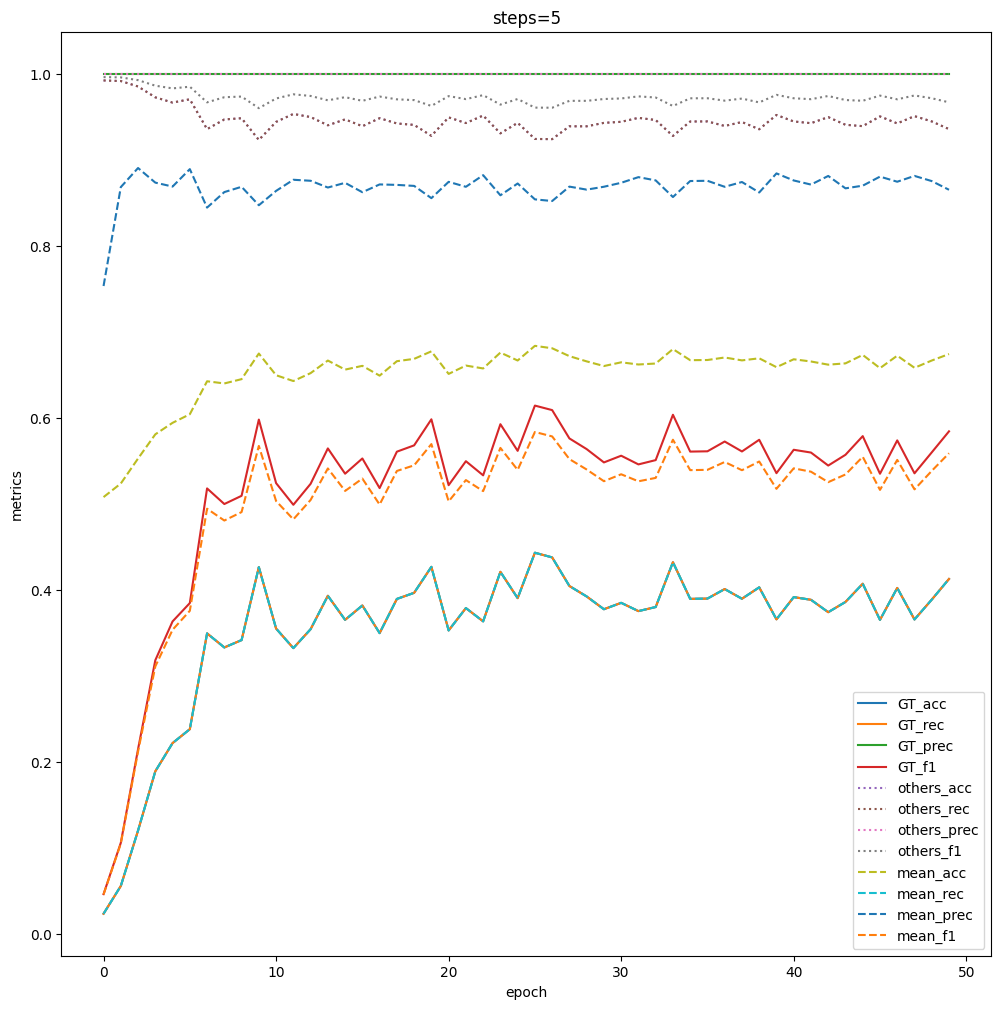

In [42]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

lr = 1e-3
epochs = 50
batch_size = 128

for topk, emb_model_update in itertools.product([10], [1]):
    print("@"*190)
    print("@"*190)
    print("@"*190)

    # Model inits
    model = CriticNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
    loss_criterion = nn.MSELoss()
    
    # Embeddings init
    embedding_model = torch.load("models/zinc2m_gin.pth").to(device)
    embedding_model.load_state_dict(model.GIN.state_dict())
    action_embeddings = get_action_dataset_embeddings(embedding_model)
    action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)
    
    # Some helper inits
    best_metric = -100
    best_model = None
    
    metric_dict = {"GT_acc": [], "GT_rec": [], "GT_prec": [], "GT_f1": [], 
                    "others_acc": [], "others_rec": [], "others_prec": [], "others_f1": [], 
                    "mean_acc": [], "mean_rec": [], "mean_prec": [], "mean_f1": [],  "time(epoch_start-now)": []}
    
    # Train the model
    for epoch in range(1, epochs+1):
        start_time = time.time()
        model.train()
        for i in range(0, train_reactants.batch_size - batch_size, batch_size):
            # Forward pass
#             qs = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size], train_rsigs[i:i+batch_size], train_psigs[i:i+batch_size])
            curr_shape = min(i+batch_size, train_reactants.batch_size) - i

            # Calc negatives
            negative_indices = []
            
            for _i in range(curr_shape):
                correct_action_dataset_index = correct_action_dataset_indices[train_idx[i+_i]]
                curr_out = action_embeddings[correct_action_dataset_index]
                dist = torch.linalg.norm(action_embeddings - curr_out, axis=1)
                sorted_idx = torch.argsort(dist)[:topk] # get topk
                sorted_idx = sorted_idx[sorted_idx != correct_action_dataset_index] # Remove if correct index in list
                negative_indices.append(sorted_idx)
                
            # critic update
            batch_reactants = train_reactants[sum([[i+_i]*(1+negative_indices[_i].shape[0]) for _i in range(curr_shape)], [])]
            batch_products = train_products[sum([[i+_i]*(1+negative_indices[_i].shape[0]) for _i in range(curr_shape)], [])]
            batch_rsigs = action_rsigs[sum([[correct_action_dataset_indices[train_idx[i+_i]]] + negative_indices[_i].tolist() for _i in range(curr_shape)], [])]
            batch_psigs = action_psigs[sum([[correct_action_dataset_indices[train_idx[i+_i]]] + negative_indices[_i].tolist() for _i in range(curr_shape)], [])]
            batch_q_targets = torch.Tensor(sum([[1] + [0] * negative_indices[_i].shape[0] for _i in range(curr_shape)], [])).view(-1, 1)

            
            qs = model(batch_reactants.to(device), batch_products.to(device), batch_rsigs.to(device), batch_psigs.to(device))
            loss = loss_criterion(qs, batch_q_targets.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Emptry any cache (free GPU memory)
            torch.cuda.empty_cache()

        print (f'Epoch {epoch}/{epochs}. Batch {i}/{train_reactants.batch_size - batch_size}. Train loss = {loss.item():.6f}')#, end='\r')
        
        model.eval()
        with torch.no_grad():
            print()

            # Update embedding model and action_embeddings
            if epoch % emb_model_update == 0:
                embedding_model.load_state_dict(model.GIN.state_dict())
                action_embeddings = get_action_dataset_embeddings(embedding_model)
                action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)

            # Predict for GT
            GT_pred_qs = (torch.concatenate([model(test_reactants[i:i+batch_size], 
                         test_products[i:i+batch_size], 
                         test_rsigs[i:i+batch_size], 
                         test_psigs[i:i+batch_size]).detach() for i in range(0, test_reactants.batch_size-batch_size, batch_size)], axis=0).cpu().numpy() > 0.5).astype(int)
#             GT_pred_qs = (model(test_reactants, test_products, test_rsigs, test_psigs).detach().cpu().numpy() > 0.5).astype(int)
            GT_true_qs = np.ones_like(GT_pred_qs)

            # Pred for others
            negative_indices = []

            for i in test_idx:
                correct_action_dataset_index = correct_action_dataset_indices[i]
                curr_out = action_embeddings[correct_action_dataset_index]
                dist = torch.linalg.norm(action_embeddings - curr_out, axis=1)

                # Get the closest that is not GT
                sorted_idx = torch.argsort(dist)[:2]
                sorted_idx = sorted_idx[sorted_idx != correct_action_dataset_index] # Remove if correct index in list
                sorted_idx = sorted_idx[:1]
                negative_indices.append(sorted_idx)

            # critic update
            test_batch_reactants = test_reactants[sum([[i]*negative_indices[i].shape[0] for i in range(test_idx.shape[0])], [])].to(device)
            test_batch_products = test_products[sum([[i]*negative_indices[i].shape[0] for i in range(test_idx.shape[0])], [])].to(device)
            test_batch_rsigs = action_rsigs[torch.concatenate(negative_indices)].to(device)
            test_batch_psigs = action_psigs[torch.concatenate(negative_indices)].to(device)

            others_pred_qs = (torch.concatenate([model(test_batch_reactants[i:i+batch_size], 
                         test_batch_products[i:i+batch_size], 
                         test_batch_rsigs[i:i+batch_size], 
                         test_batch_psigs[i:i+batch_size]).detach() for i in range(0, test_batch_reactants.batch_size-batch_size, batch_size)], axis=0).cpu().numpy() > 0.5).astype(int)
            others_true_qs = np.zeros_like(others_pred_qs)

            # Update metrics (with inverted labels -- sklearn considers 0 as true class in confusion matrix)
            acc, (prec, rec, f1, _) = accuracy_score(GT_true_qs, GT_pred_qs), precision_recall_fscore_support(GT_true_qs, GT_pred_qs, average="binary")
            metric_dict["GT_acc"].append(acc); metric_dict["GT_rec"].append(rec); metric_dict["GT_prec"].append(prec); metric_dict["GT_f1"].append(f1)

            # 1-others in prec_rec_f1 because sklearn wants true class as 1 and others has true class 0 (only for the sake of metric scores)
            acc, (prec, rec, f1, _) = accuracy_score(others_true_qs, others_pred_qs), precision_recall_fscore_support(1-others_true_qs, 1-others_pred_qs, average="binary") 
            metric_dict["others_acc"].append(acc); metric_dict["others_rec"].append(rec); metric_dict["others_prec"].append(prec); metric_dict["others_f1"].append(f1)

            mean_pred_qs = np.concatenate([GT_pred_qs, others_pred_qs], axis=0)
            mean_true_qs = np.concatenate([GT_true_qs, others_true_qs], axis=0)
            acc, (prec, rec, f1, _) = accuracy_score(mean_true_qs, mean_pred_qs), precision_recall_fscore_support(mean_true_qs, mean_pred_qs, average="binary")
            metric_dict["mean_acc"].append(acc); metric_dict["mean_rec"].append(rec); metric_dict["mean_prec"].append(prec); metric_dict["mean_f1"].append(f1)

            # Print
            metric_df = pd.DataFrame(columns=["GT_acc", "GT_rec", "GT_prec", "GT_f1", "others_acc", "others_rec", "others_prec", "others_f1", 
                                              "mean_acc", "mean_rec", "mean_prec", "mean_f1",  "time(epoch_start-now)"])

            metric_dict["time(epoch_start-now)"].append(f"{(time.time()-start_time)/60:.2f} min")
            for col in metric_df.columns:
                metric_df[col] = [metric_dict[col][-1]]
            metric_df.index = [epoch]
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()

            

        # Update best model (with GT f1 - we want critic for best GT)
        metric_for_best_model = "GT_f1"
        curr_metric = metric_dict[metric_for_best_model][-1]
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_model = type(model)()
            best_model.load_state_dict(model.state_dict())
            best_epoch = epoch
            print(f"BEST MODEL UPDATED! BEST {metric_for_best_model} = {best_metric}")

    # save everything
    folder = f"models/supervised/critic/emb_model_update={emb_model_update}||steps={steps}||topk={topk}"
    os.makedirs(folder, exist_ok = True)
    torch.save(model, os.path.join(folder, "model.pth"))
    pd.DataFrame.from_dict(metric_dict).to_csv(os.path.join(folder, "metrics.csv"))

    # Save plots
    fig = plt.figure(figsize=(12, 12))
    line_style = {"GT": "-", "others": ":", "mean": "--"}
    for metric in filter(lambda x: "time" not in x, metric_dict.keys()):
        plt.plot(metric_dict[metric], label=metric, linestyle=line_style[metric.split("_")[0]])
    plt.title(f"steps={steps}")
    plt.xlabel("epoch")
    plt.ylabel("metrics")
    plt.legend()
    fig.savefig(os.path.join(folder, "plot.png"))

    json.dump({
        "steps(trajectory length)": steps,
        "lr": lr,
        "epochs": epochs, 
        "batch_size": batch_size,
        "train_samples": train_idx.shape,
        "test_samples": test_idx.shape,
        "topk": topk,
        "emb_model_update": emb_model_update,
        "best_epoch": best_epoch,
        f"best_{metric_for_best_model}": best_metric,
    }, open(os.path.join(folder, "config.txt"), 'w'))
    print("Saved model at", folder)